<a href="https://colab.research.google.com/github/AraiKensuke/GCoh/blob/Include_dpss_bw_in_preprocessver/cluster_eeg_gcoh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Demonstration of sliding-window Global Coherence analysis on 21-channel dry-electrode EEG data**

#1)  Install GCoh package

In [1]:
#########  clone and install necessary packages from github repositories


import sys
import importlib

if importlib.util.find_spec("GCoh") is None:
  !git clone https://github.com/AraiKensuke/GCoh.git

if importlib.util.find_spec("mne") is None:
  !pip install mne

sys.path.insert(1, "/content/GCoh")    #  add these to searchpath for python module

Cloning into 'GCoh'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 254 (delta 5), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (254/254), 4.70 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (150/150), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 15.1 MB/s 


#  2) Upload EDF file to Colab

Enter filename down below.

Then goto "File" space on the left, choose the upload icon, and upload an EDFfile

Type in filename of uploaded file in to variable "dat"

In [25]:
#dat="8_12_2min_raw[11973].edf"
#dat="Jan092020_15_05_39_artfctrmvd_v1.edf"
dat="Feb132021_23_09_09_artfctrmvd_v1.edf"

#  3) Prepare the data

In [38]:
import numpy as _N
import scipy.io as _scio
import scipy.stats as _ss
import matplotlib.pyplot as _plt
from scipy.signal import savgol_filter
from sklearn import mixture
import mne
from GCoh.eeg_util import unique_in_order_of_appearance, increasing_labels_mapping, rmpd_lab_trnsfrm, find_GMM_labels, shift_correlated_shuffle, mtfftc
import GCoh.skull_plot as _sp
import os
#import AIiRPS.rpsms as rpsms
import GCoh.preprocess_ver as _ppv
#from AIiRPS.utils.dir_util import getResultFN
import GCoh.datconfig as datconf

import GCoh.windowed_gcoh as _w_gcoh
import warnings
warnings.filterwarnings("ignore")

os.environ["GCoh_on_colab"] = "1"

import sys

def showEEG(t0, t1, evry=1,  bpfilter=None):
  lblsz=14
  tksz=12
  ch_w_CM, rm_chs, ch_names, ch_types = datconf.getConfig(datconf._RPS, cm=None)

  EEG = eeg_LP[ch_w_CM]
  
  if bpfilter is not None:
    l_freq=bpfilter[0]
    h_freq=bpfilter[1]
    showEEG = mne.filter.filter_data(EEG, Fs, l_freq, h_freq, verbose=False)
  else:
    showEEG = EEG
  fig = _plt.figure(figsize=(13, 22))
  _plt.suptitle("t0: %(0)ds    t1: %(1)ds" % {"0" : t0, "1" : t1}, fontsize=(lblsz+2))
  maxY  = _N.max(showEEG[:, t0*Fs:t1*Fs])
  minY  = _N.min(showEEG[:, t0*Fs:t1*Fs])
  A     = maxY - minY
  for ich  in range(nChs):
      fig.add_subplot(nChs, 1, ich+1)
      _plt.plot(showEEG[ich, t0*Fs:t1*Fs], color="black")
      if ich == nChs-1:
        _plt.xticks(_N.linspace(0, (t1-t0)*Fs, (t1-t0)//evry, endpoint=False), _N.arange(t0, t1, evry), fontsize=tksz)
        _plt.xlabel("time (s)", fontsize=lblsz)
      else:
        _plt.xticks(_N.linspace(0, (t1-t0)*Fs, (t1-t0)//evry, endpoint=False), [""]*((t1-t0)//evry))
      _plt.xlim(0, (t1-t0)*Fs)
      _plt.ylim(minY-0.05*A, maxY+0.05*A) 
      _plt.yticks([])
      _plt.ylabel("ch %d" % (ich+1), fontsize=lblsz)

def calc_gcoh(X_cm, datset, bad_chs, wnd, slideby):
  #  assign a version number for GCoh calculation here.

  #wnd, slideby      = preprocess_ver.get_win_slideby(gcoh_ver)

  #cm    = 9     #  this is when using Q20
  cm    = None   #  this is when using DSi

  ch_w_CM, rm_chs, ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10, cm=cm)

  if bad_chs is not None:
      rm_chs.extend(bad_chs)
  ch_picks = _N.setdiff1d(ch_w_CM, _N.array(rm_chs))
  arr_ch_picks = _N.array(ch_picks)

  info = mne.create_info(ch_names=(_N.array(ch_names)[ch_picks]).tolist(), ch_types=(_N.array(ch_types)[ch_picks]).tolist(), sfreq=Fs)

  datconf.set_montage(dataset, info)

  dpss_bw=7
  f, findx, Ctot, Cvec = _w_gcoh.windowed_gcoh(Fs, wnd, slideby, X_cm, ch_w_CM, ch_picks, info, dpss_bw=dpss_bw)

  pkldat = {"VEC" : Cvec, "Cs" : Ctot, "fs" : f[findx], "chs_picks" : arr_ch_picks, "dpss_bw" : dpss_bw}

  return pkldat

def depickle(s):
     import pickle
     with open(s, "rb") as f:
          lm = pickle.load(f)
     return lm


dataset =    datconf._RPS
c    = 2
if dataset == datconf._SIM:
    Fs   = 200
if dataset == datconf._RPS or dataset == datconf._STROOP:
    Fs   = 300
elif dataset == datconf._GONOGO:
    Fs   = 500
elif dataset == datconf._AAFFECT:
    Fs   = 500

ch_w_CM, rm_chs, list_ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10)
arr_ch_names = _N.array(list_ch_names)

arr_ch_names=_N.array(["P3", "C3", "F3", "Fz", "F4",   
                       "C4", "P4", "Cz", "Pz", "A1",    #  "Pz" is "CM"
                       "Fp1","Fp2","T3", "T5", "O1",
                       "O2", "F7", "F8", "A2", "T6",
                       "T4"])
ch_names=_N.array(["P3", "C3", "F3", "Fz", "F4",   
                       "C4", "P4", "Cz", "Pz", "A1",    #  "Pz" is "CM"
                       "Fp1","Fp2","T3", "T5", "O1",
                       "O2", "F7", "F8", "A2", "T6",
                       "T4"])
ev_n   = 0

####  Calculate GCoH over window size win, then slide by "slideby" to do calculation of next window 
win=512
slideby=64

hlfOverlap = int((win/slideby)*0.5)

eegedf = mne.io.read_raw_edf(dat)
eegdat = eegedf.get_data()

####  Low-pass filter the channels
eeg_LP = _N.array(eegdat)

for ich in range(25):
    eeg_LP[ich] = mne.filter.filter_data(eegdat[ich], 300, 1, 100, verbose=False)
    eeg_LP[ich] /= _N.std(eeg_LP[ich])

Extracting EDF parameters from /content/Feb132021_23_09_09_artfctrmvd_v1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


# 4) Now run GCoh on LPd EEG data

In [39]:
gcoh_pkl = calc_gcoh(eeg_LP.T, dataset, None, 512, 64)
vec_mag = _N.abs(gcoh_pkl["VEC"])
fs_gcoh = gcoh_pkl["fs"]

    Using multitaper spectrum estimation with 11 DPSS windows
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
win 0 of 630
win 20 of 630
win 40 of 630
win 60 of 630
win 80 of 630
win 100 of 630
win 120 of 630
win 140 of 630
win 160 of 630
win 180 of 630
win 200 of 630
win 220 of 630
win 240 of 630
win 260 of 630
win 280 of 630
win 300 of 630
win 320 of 630
win 340 of 630
win 360 of 630
win 380 of 630
win 400 of 630
win 420 of 630
win 440 of 630
win 460 of 630
win 480 of 630
win 500 of 630
win 520 of 630
win 540 of 630
win 560 of 630
win 580 of 630
win 600 of 630
win 620 of 630


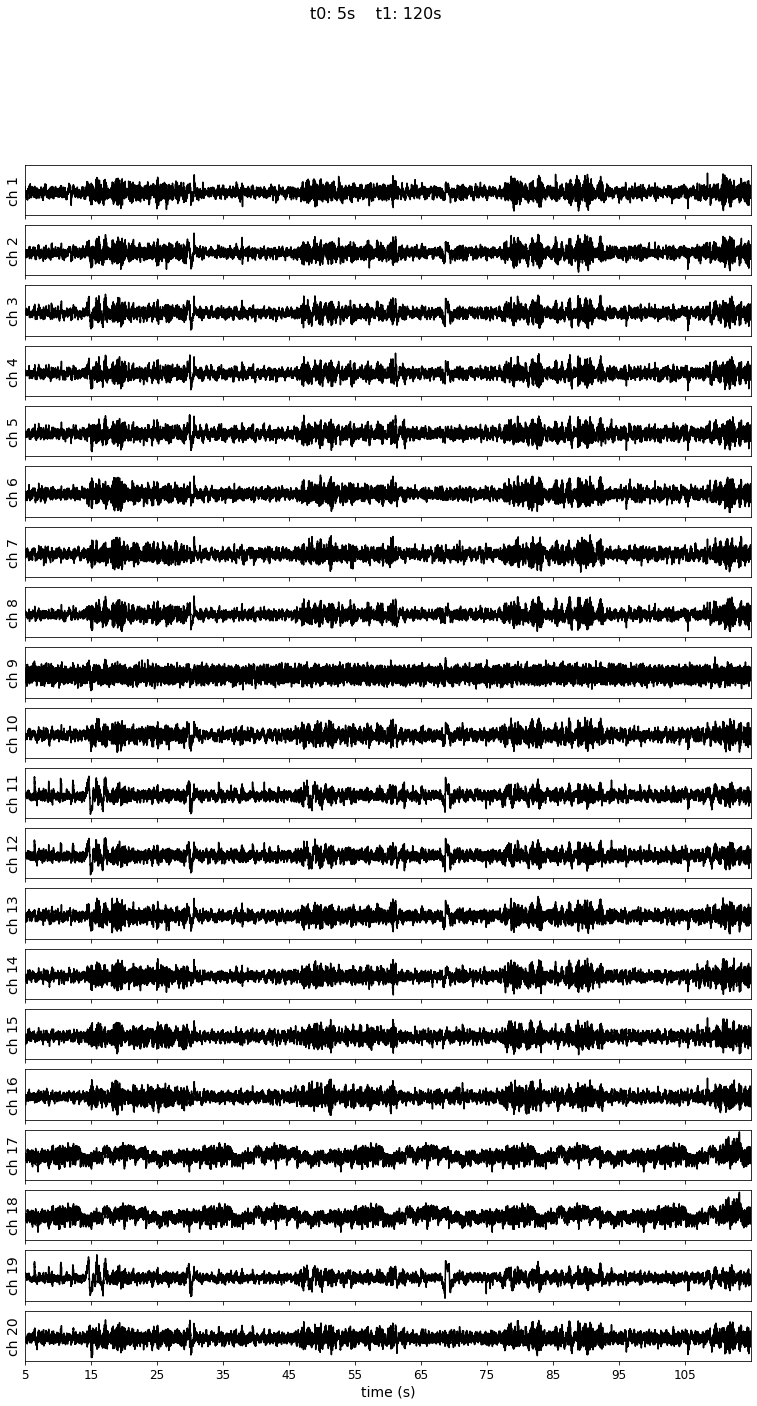

In [41]:
showEEG(5, 120, 10)

# 5) Plot the EV timeseries, cluster them and show skull plots of coherence states

2
20
2
(20, 2)
(1, 20, 2)
2
20
2
(20, 2)
(1, 20, 2)
2
20
2
(20, 2)
(1, 20, 2)
2
20
2
(20, 2)
(1, 20, 2)


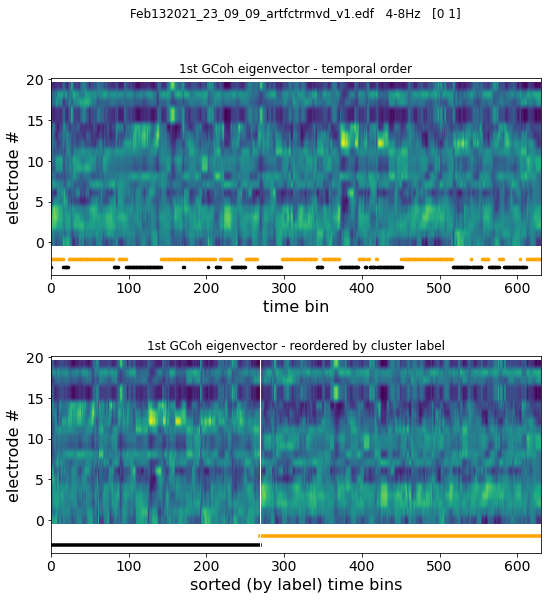

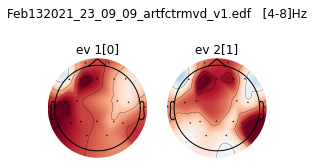

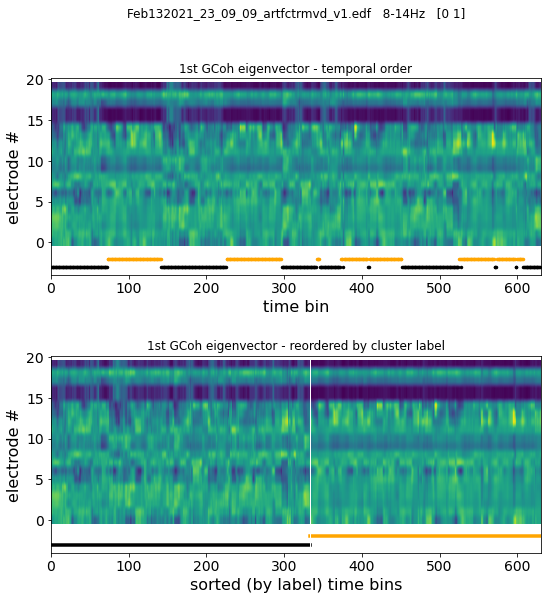

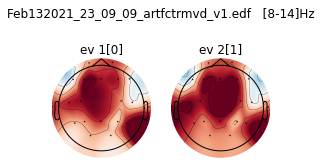

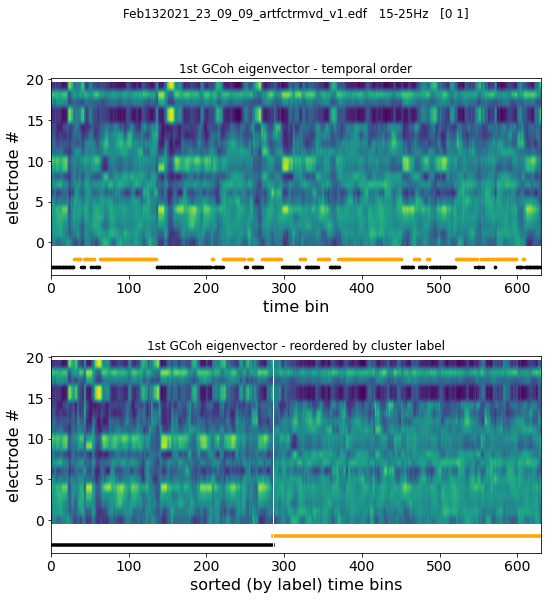

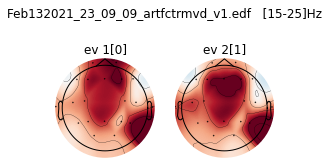

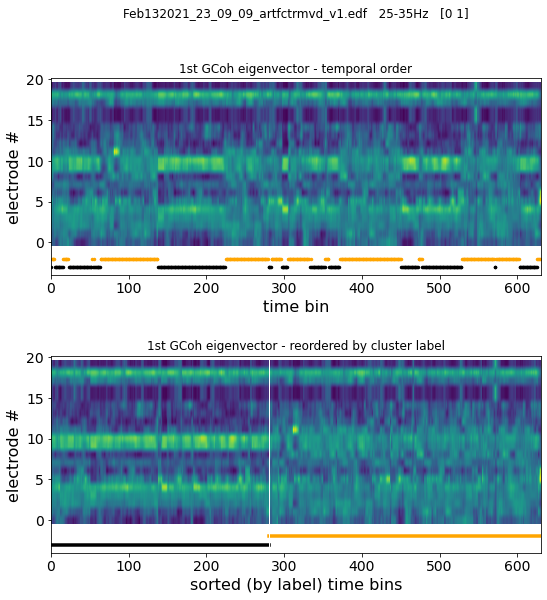

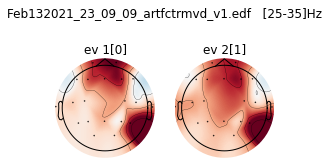

In [34]:
from GCoh.eeg_util import find_GMM_labels

L_gcoh = vec_mag.shape[0]
nChs   = vec_mag.shape[3]

f_ranges = [[4, 8], [8, 14], [15, 25], [25, 35]]

for ich in range(len(f_ranges)):
    fL = f_ranges[ich][0]
    fH = f_ranges[ich][1]

    irngs = _N.where((fs_gcoh > fL) & (fs_gcoh < fH))[0]
    iL    = irngs[0]
    iH    = irngs[-1]    


    gcoh_frng = _N.mean(vec_mag[:, irngs], axis=1)
    #Apr242020_16_53_03_gcoh_256_64
    nStates, rmpd_lab = find_GMM_labels(gcoh_frng[:, 0], try_K=[1, 2, 3, 4, 5], TRs=[1, 3, 5, 10, 10])
    ps = _N.arange(nStates)
    #ps += nState_start
    #nState_start += nStates
    print(nStates)


    

    out_u = _N.mean(vec_mag[:, iL:iH, 0], axis=1)
    out = _N.empty((L_gcoh, nChs))
    iS  = 0
    for ns in range(nStates):    #  sorted eigenvectors
        ls = _N.where(rmpd_lab == ns)[0]
        out[iS:iS+len(ls)] = _N.mean(vec_mag[ls, iL:iH, 0], axis=1)
        iS += len(ls)

    iS = 0
    clrs  = ["black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red"]
    W   = L_gcoh
    H   = nChs
    disp_wh_ratio = 3
    aspect = (W/H)/disp_wh_ratio
    unit = 2.5

    fig = _plt.figure(figsize=(disp_wh_ratio*unit + 1, 3*unit+unit/2))
    _plt.subplot2grid((2, 1), (0, 0))        
    _plt.title("1st GCoh eigenvector - temporal order")
    #fig.add_subplot(nStates+2, 1, 1)  
    _plt.imshow(out_u.T, aspect=aspect)
    _plt.ylim(-(nStates+2), nChs+0.1)
    for ns in range(nStates):
        nsx = _N.where(rmpd_lab == ns)[0]
        _plt.scatter(nsx, _N.ones(len(nsx))*ns - nStates - 1, color=clrs[ns], lw=1.5, s=4)
    _plt.xlim(0, L_gcoh)
    _plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
    _plt.ylabel("electrode #", fontsize=16)
    _plt.xlabel("time bin", fontsize=16)
    _plt.xticks(fontsize=14)
    _plt.yticks(fontsize=14)
    _plt.subplot2grid((2, 1), (1, 0))        
    _plt.title("1st GCoh eigenvector - reordered by cluster label")
    #fig.add_subplot(nStates+2, 1, 1)    
    _plt.imshow(out.T, aspect=aspect)
    _plt.ylim(-(nStates+2), nChs+0.1)
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        liS = iS
        iS += len(ls)
        _plt.plot([liS, iS], [ns-nStates-1, ns-nStates-1], color=clrs[ns], lw=3.5)
        if ns < nStates-1:
            _plt.axvline(x=iS, color="white", lw=1)
    _plt.xlim(0, L_gcoh)
    _plt.suptitle("%(ky)s   %(1)d-%(2)dHz   %(sts)s" % {"1" : fL, "2" : fH, "ky" : dat, "sts" : str(ps)})
    _plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
    _plt.ylabel("electrode #", fontsize=16)
    _plt.xlabel("sorted (by label) time bins", fontsize=16)
    _plt.xticks(fontsize=14)
    _plt.yticks(fontsize=14)
    
    

    iS = 0
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        iS += len(ls)
        if ns < nStates-1:
            _plt.axvline(x=iS, color="white", lw=1)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, hspace=0.3)


    max_over_fs_each_state = _N.empty((nChs, nStates))
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        mn_over_fs = _N.mean(vec_mag[:, iL:iH, 0], axis=1)
        #min_all    = _N.min(mn_over_fs, axis=0)
        max_over_fs_each_state[:, ns]    = _N.max(mn_over_fs, axis=0)
    maxComp = _N.max(max_over_fs_each_state)

    all_vecs = _N.empty((nChs, nStates))
    
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        mn_over_fs = _N.mean(vec_mag[ls, iL:iH, 0], axis=1)
        min_all    = _N.min(mn_over_fs, axis=0)
        all_vecs[:, ns] = (min_all / maxComp)*1e-5
    _sp.do_skull_plot_all_EVs(all_vecs, ps, ch_names, "temp", dat, fL, fH)



